# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains 10 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

## Section 1: Preparing the vocabulary

In [2]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [3]:
#TODO
def prepare_vocabulary(file_path):
    with open(file_path, 'r') as file:
        words = [word.strip().lower() for word in file.readlines()]
    
    filtered_words = [word for word in words if 3 < len(word) <= WORD_SIZE]
    vocab = [word.ljust(WORD_SIZE, '_') for word in filtered_words]
    
    return vocab

file_path = 'wordlist.txt'
vocab = prepare_vocabulary(file_path)

for i in range(10):
    print(vocab[i])



aaron________
abandoned____
aberdeen_____
abilities____
ability______
able_________
aboriginal___
abortion_____
about________
above________


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer**
<font color='green'>

The practical reason for using words longer than 3 letters and limiting the maximum length is to make the training process easier and more efficient.

1) Short words are too simple: Words with 1-3 letters (like "cat" or "the") are too short to learn meaningful patterns. These words don’t give the model much useful information for understanding how letters relate to each other.

2) Long words add complexity: If we allow very long words, the model becomes harder to train because it has to handle more possibilities and remember longer sequences. This can make training slower and increase errors.

By focusing on words between 4 and 13 letters, we keep a balance, the model gets enough information to learn meaningful patterns without being overwhelmed by too much complexity. This helps the model perform better in predicting word completions.
</font>

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [4]:
def char_to_num(char):

    #TODO
    if char == '_':
        num = 0
    elif char.isalpha() and char.islower():
        num = ord(char) - ord('a') + 1
    else:
        raise ValueError(f"Invalid character: {char}")

    return(num)

def num_to_char(num):

    #TODO
    if num == 0:
        char = '_'
    elif 0 < num <= 26:
        char = chr(num + ord('a') - 1)
    else:
        raise ValueError(f"Out of range number: {num}")

    return(char)

def word_to_numlist(word):

    #TODO
    numlist = torch.tensor([char_to_num(char) for char in word])

    return(numlist)

def numlist_to_word(numlist):

    #TODO
    word = ''.join(num_to_char(num.item()) for num in numlist)

    return(word)

<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

**Answer**
<font color='green'>

Converting letters into numbers based on their alphabetical order (such as 'a' -> 1, 'b' -> 2, etc.) is indeed a bad way to encode letters for a learning model. This is because there is no meaningful relationship between the numerical values assigned to the letters. For example, just because 'a' is assigned 1 and 'b' is assigned 2, it doesn’t mean that 'b' is "greater" or "closer" to 'a' in any meaningful way for a machine learning model. This is the same problem we encounter with categorical data: categories like "apple" and "orange" shouldn’t have a natural order like numbers do, so simply assigning them numbers can mislead the model into thinking that there is some kind of relationship between these numbers.

Even though this claim is valid, it won't be an issue in our case because we will use something called an embedding layer. An embedding layer maps each letter to a dense vector in a continuous space. These vectors are learned during training, and they help the model understand relationships between letters in a more meaningful way. For example, letters that often appear together in words will have vectors that are closer to each other, while letters that don’t have much in common will have vectors that are farther apart.

So, while simple numerical encoding is not ideal, the embedding layer will learn and adjust the representations, allowing the model to perform better.
</font>

## Section 2: Implementing the Autocomplete model

We will implement a RNN model based on LSTM. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [5]:
LEARNING_RATE = 0.005

In [6]:
class autocompleteModel(nn.Module):
    # Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()

        # Set the input parameters to self parameters
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Initialize the layers in the model
        #1 embedding layer, 1 - LSTM cell (hidden layer), 1 fully connected layer with linear activation
        self.embed_layer = nn.Embedding(self.alphabet_size, self.embed_dim)
        self.LSTM = nn.LSTM(self.embed_dim, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.alphabet_size)

    # Feedforward
    def forward(self, character, hidden_state, cell_state):
        #Perform feedforward in order
        #1. Embed the input (one charcter represented by a number)
        #2. Feed the embedded output to the LSTM cell
        #3. Feed the LSTM output to the fully connected layer to obtain the output
        #4. return the output, and both the hidden state and cell state from the LSTM cell output
        embedding = self.embed_layer(character)
        lstm_out, (hidden_state, cell_state) = self.LSTM(embedding.view(1, 1, -1), (hidden_state, cell_state))
        output = self.fc(lstm_out.view(1, -1))
        return output, hidden_state, cell_state

    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size)
        return (h0, c0)

    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs=5, batch_size=100):

        #Convert the model into train mode
        self.train()
        #Set the optimizer (ADAM), you may need to provide the model parameters  and learning rate
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        #Keep a log of the loss at the end of each training cycle.
        loss_log = []

        for e in range(epochs):

            #TODO: Shuffle the vocab list the start of each epoch
            random.shuffle(vocab)
            num_iter = len(vocab) // batch_size
            batch_loss_list = []

            for i in tqdm(range(num_iter), desc=f" Training - Epoch {e + 1}/{epochs} ", unit="batch"):

                #TODO: Set the loss to zero, initialize the optimizer with zero_grad at the beginning of each training cycle.
                batch_loss = 0
                optimizer.zero_grad()

                # Extract the batch
                vocab_batch = vocab[i * batch_size:(i + 1) * batch_size]

                for word in vocab_batch:
                    #TODO: Initialize the hidden state and cell state at the start of each word.
                    hidden_state, cell_state = self.initial_state()

                    #TODO: Convert the word into a tensor of number and create input and target from the word
                    #Input will be the first WORD_SIZE - 1 charcters and target is the last WORD_SIZE - 1 charcters
                    input_tensor = word_to_numlist(word[:WORD_SIZE - 1])
                    target_tensor = word_to_numlist(word[1:WORD_SIZE])

                    # Loop through each character in the word
                    for c in range(WORD_SIZE - 1):
                        #TODO: Feed the cth character to the model (feedforward) and comput the loss (use cross entropy in torch)
                        output, hidden_state, cell_state = self.forward(input_tensor[c].unsqueeze(0), hidden_state, cell_state)
                        loss = nn.functional.cross_entropy(output, target_tensor[c].view(1))
                        batch_loss += loss

                #TODO: Compute the average loss per word in the batch and perform backpropagation (.backward())
                batch_loss /= len(vocab_batch)
                batch_loss.backward()

                #TODO: Update model parameters using the optimizer
                optimizer.step()
                #Update the loss_log 
                batch_loss_list.append(batch_loss.item())

            print("Epoch: ", e + 1, " Training loss per word : ", batch_loss.item())
            loss_log.append(np.mean(batch_loss_list))

        #TODO Plot a graph of the variation of the loss.
        plt.figure(figsize=(8, 6))
        plt.plot(loss_log)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss vs Epochs')
        plt.show()

    #Perform autocmplete given a sample of strings (typically 3-5 starting letters)
    def autocomplete(self, sample):
        #Convert the model into evaluation mode
        self.eval()
        completed_list = []

        #TODO: In the following loop for each sample item initialize hidden and cell states, then predict the remaining characters
        for i in tqdm(range(len(sample)), desc="Prediction", unit="word"):
            literal = sample[i]
            hidden_state, cell_state = self.initial_state()
            input_tensor = word_to_numlist(literal)
            predicted = literal

            for p in range(len(literal) - 1):
                init_input = input_tensor[p].unsqueeze(0)
                _, hidden_state, cell_state = self.forward(init_input, hidden_state, cell_state)

            init_input = input_tensor[-1].unsqueeze(0)

            #You will have to convert the output into a softmax (you may use your softmax method from the last project) probability distribution, then use torch.multinomial 
            for g in range(WORD_SIZE):
                output, hidden_state, cell_state = self.forward(init_input, hidden_state, cell_state)
                output_prob = nn.functional.softmax(output, dim=1)
                top_1 = torch.multinomial(output_prob, 1)[0]
                pred_char = num_to_char(top_1.item())
                predicted += pred_char
                init_input = torch.tensor(char_to_num(pred_char)).unsqueeze(0)

            completed_list.append(predicted)

        return(completed_list)

## Section 3: Using and evaluating the model

(i) Feel free to initialize a autocompleteModel using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can. Show the loss curves in you answers.

(ii) Evaluate it on different samples of partially filled in words. Eg: ["univ", "math", "neur", "engin"] etc. Please show outputs for different samples.

<font color='blue'>Comment on the results. Is it successful? Do you see familiar substrings in the generated tesxt such as "tion", "ing", "able" etc. What are your suggestions to improve the model?</font>

In [7]:
model = autocompleteModel( alphabet_size = 27 ,
                           embed_dim = 100, 
                           hidden_size = 128, 
                           num_layers = 1)

 Training - Epoch 1/20 : 100%|██████████| 88/88 [01:28<00:00,  1.00s/batch]


Epoch:  1  Training loss per word :  14.568717002868652


 Training - Epoch 2/20 : 100%|██████████| 88/88 [01:34<00:00,  1.07s/batch]


Epoch:  2  Training loss per word :  14.169864654541016


 Training - Epoch 3/20 : 100%|██████████| 88/88 [01:35<00:00,  1.09s/batch]


Epoch:  3  Training loss per word :  13.524555206298828


 Training - Epoch 4/20 : 100%|██████████| 88/88 [01:36<00:00,  1.10s/batch]


Epoch:  4  Training loss per word :  13.2160062789917


 Training - Epoch 5/20 : 100%|██████████| 88/88 [01:35<00:00,  1.09s/batch]


Epoch:  5  Training loss per word :  13.305241584777832


 Training - Epoch 6/20 : 100%|██████████| 88/88 [01:35<00:00,  1.08s/batch]


Epoch:  6  Training loss per word :  11.641826629638672


 Training - Epoch 7/20 : 100%|██████████| 88/88 [01:34<00:00,  1.08s/batch]


Epoch:  7  Training loss per word :  11.182146072387695


 Training - Epoch 8/20 : 100%|██████████| 88/88 [01:37<00:00,  1.10s/batch]


Epoch:  8  Training loss per word :  11.243267059326172


 Training - Epoch 9/20 : 100%|██████████| 88/88 [01:35<00:00,  1.08s/batch]


Epoch:  9  Training loss per word :  11.235906600952148


 Training - Epoch 10/20 : 100%|██████████| 88/88 [01:36<00:00,  1.09s/batch]


Epoch:  10  Training loss per word :  10.815437316894531


 Training - Epoch 11/20 : 100%|██████████| 88/88 [01:38<00:00,  1.12s/batch]


Epoch:  11  Training loss per word :  10.749048233032227


 Training - Epoch 12/20 : 100%|██████████| 88/88 [01:36<00:00,  1.09s/batch]


Epoch:  12  Training loss per word :  10.433521270751953


 Training - Epoch 13/20 : 100%|██████████| 88/88 [01:34<00:00,  1.08s/batch]


Epoch:  13  Training loss per word :  9.902721405029297


 Training - Epoch 14/20 : 100%|██████████| 88/88 [01:39<00:00,  1.13s/batch]


Epoch:  14  Training loss per word :  10.618120193481445


 Training - Epoch 15/20 : 100%|██████████| 88/88 [01:37<00:00,  1.11s/batch]


Epoch:  15  Training loss per word :  10.213113784790039


 Training - Epoch 16/20 : 100%|██████████| 88/88 [01:43<00:00,  1.17s/batch]


Epoch:  16  Training loss per word :  9.655303001403809


 Training - Epoch 17/20 : 100%|██████████| 88/88 [01:42<00:00,  1.16s/batch]


Epoch:  17  Training loss per word :  9.821187019348145


 Training - Epoch 18/20 : 100%|██████████| 88/88 [01:35<00:00,  1.08s/batch]


Epoch:  18  Training loss per word :  9.413468360900879


 Training - Epoch 19/20 : 100%|██████████| 88/88 [01:34<00:00,  1.07s/batch]


Epoch:  19  Training loss per word :  9.875690460205078


 Training - Epoch 20/20 : 100%|██████████| 88/88 [01:35<00:00,  1.08s/batch]

Epoch:  20  Training loss per word :  9.548742294311523


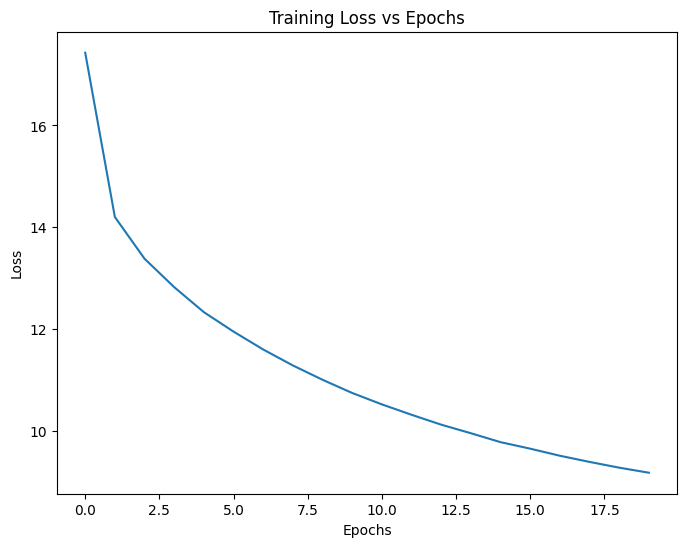

In [8]:
model.trainModel(vocab = vocab, epochs = 20)

In [23]:
model.autocomplete(["univ", "math", "neur", "engin"])

Prediction: 100%|██████████| 4/4 [00:00<00:00, 144.22word/s]


['universe_________',
 'mathelled________',
 'neural___________',
 'engineer__________']

In [57]:
model.autocomplete(["equa", "exce", "impr", "gener", "transl", "valu"])

Prediction: 100%|██████████| 6/6 [00:00<00:00, 133.63word/s]


['equal____________',
 'excellent________',
 'improvings_______',
 'general___________',
 'translation________',
 'valuation________']

**Answer**

<font color='green'>

Results Analysis:

"univ" → "universe_________"
The completion of "univ" to "universe" is accurate and relevant, suggesting the model learned the correct continuation.

"math" → "mathelled________"
This result is less satisfactory. "Mathelled" is not a valid word, and the model might be struggling to find a familiar continuation for "math."

"neur" → "neural___________"
"Neural" is a valid word and a correct prediction. The model likely learned medical or biological terminology.

"engin" → "engineer__________"
"Engineer" is a sensible completion and correct.

"equa" → "equal____________"
"Equal" is a correct and valid word completion.

"exce" → "excellent________"
"Excellent" is another correct prediction, which is highly relevant.

"impr" → "improvings_______"
The prefix "impr" is correctly continued with "improvings," though this is grammatically incorrect. It might have been expected to generate "improvement" or "improving."

"gener" → "general___________"
"General" is a common and valid word completion.

"transl" → "translation________"
"Translation" is a proper completion, matching the expected pattern.

"valu" → "valuation________"
"Valuation" is a valid and correct completion.

Familiar Substrings
- We do see familiar substrings like "tion" in "translation" and "valuation" as well as "ing" in "improvings". However, there are issues in words like "mathelled" and "improvings," where the model generates inaccurate endings.

Suggestions for Improvement
- Train longer: Increase the number of training epochs to help the model learn better word patterns.

- Improve training data: Use a larger and more varied dataset to help the model predict words more accurately.

- Use pretrained embeddings: Try using word embeddings like GloVe or FastText, which already know many words and their meanings.

- Add dropout: Include dropout layers in the model to prevent it from memorizing specific patterns and help it generalize better.

</font>